In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#todo: write up: explain is a form of ensembling, so accuracy good, but 
# explainable. 
# - add regression
# - test using dataset_tester() tool. can just compare to plain knn for accuracy
#     if it's similar f1 score, we're okay. can just show is interpretable
# - test if this is less sensitive to k than normal kNN
# explain: the difference in the f1 scores for different folds can be 
#    quite large. eg spam7.
# all todo points here and in code
# include this notbook as a simple test, but another for a full test with 
#    the public datasets. In that one, test both: 1) with both using 
#    default hyperparams; 2) both using a grid search to get the hyperparams.
# run the grid search on many public datasets to get a good sense what the 
#    default params should be. 
# investigate cases where f1 score lower than sklearn's f1 score

In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from statistics import stdev, mean

import sys  
sys.path.insert(0, 'C:\\python_projects\\ikNN_project\\ikNN')
from interpretable_knn import interpretable_knn

## Methods to load sklearn toy datasets

In [4]:
# This cell provides methods to test with 3 of the toy datasets provided by sklearn. For consistency,
# we load each X as a pandas dataframe and y as a numpy array.
# todo: that's weird, make y a series

def get_iris():
    iris = load_iris()
    X, y = iris.data, iris.target
    X = pd.DataFrame(X, columns=iris['feature_names'])
    return X, y

def get_breast_cancer():
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)
    return X, y.values

def get_wine():
    X, y = load_wine(return_X_y=True, as_frame=True)
    return X, y.values

## Example running both sklearn's kNN and interpretable_knn on the toy datasets

In [5]:
# Test sklearn's kNN as well as interpretable_knn. In both cases, the default hyperparameters are used. 
# This provides a simple example where the accuracy of interpretable_knn is comparable to sklearn's
# kNN and often higher.

def test_classification(X, y):
    
    def test_sklearn_knn():    
        clf = KNeighborsClassifier()
        scores = cross_validate(clf, X, y, cv=5, scoring='f1_macro', return_train_score=True)
        return scores
    
    def test_2d_knn():       
        clf = interpretable_knn()
        scores = cross_validate(clf, X, y, cv=5, scoring='f1_macro', return_train_score=True)
        return scores
    
    def print_scores(scores):    
        train_scores = scores['train_score']
        test_scores = scores['test_score']
        avg_train_score = mean(train_scores)
        avg_test_score = mean(test_scores)
        scores_std_dev = stdev(test_scores)

        print("\nAverage f1 score on training data: ", round(avg_train_score,3))
        print("Average f1 score on test data: ", round(avg_test_score,3))
        print("Std dev of f1 scores on test data: ", round(scores_std_dev,3))
        
    print_scores(test_sklearn_knn())
    print_scores(test_2d_knn())

# Given a method to load a dataset, load the dataset and test the accuracy of a sklearn decision tree with and without
# the extended features.
def test_dataset(load_method, file_name):
    print("\n\n*********************************************")
    print("Calling for " + file_name)
    print("*********************************************")
    
    X,y = load_method()
    test_classification(X, y)
    
test_dataset(get_iris, "Iris")
test_dataset(get_breast_cancer, "Breast Cancer")
test_dataset(get_wine, "Wine")



*********************************************
Calling for Iris
*********************************************

Average f1 score on training data:  0.97
Average f1 score on test data:  0.973
Std dev of f1 scores on test data:  0.028

Average f1 score on training data:  0.967
Average f1 score on test data:  0.96
Std dev of f1 scores on test data:  0.028


*********************************************
Calling for Breast Cancer
*********************************************

Average f1 score on training data:  0.943
Average f1 score on test data:  0.922
Std dev of f1 scores on test data:  0.028

Average f1 score on training data:  0.941
Average f1 score on test data:  0.898
Std dev of f1 scores on test data:  0.031


*********************************************
Calling for Wine
*********************************************

Average f1 score on training data:  0.772
Average f1 score on test data:  0.671
Std dev of f1 scores on test data:  0.052

Average f1 score on training data:  0.942
Av

## Example Visualizing the model



*********************************************
Calling for Iris
*********************************************
wrong_rows:  []


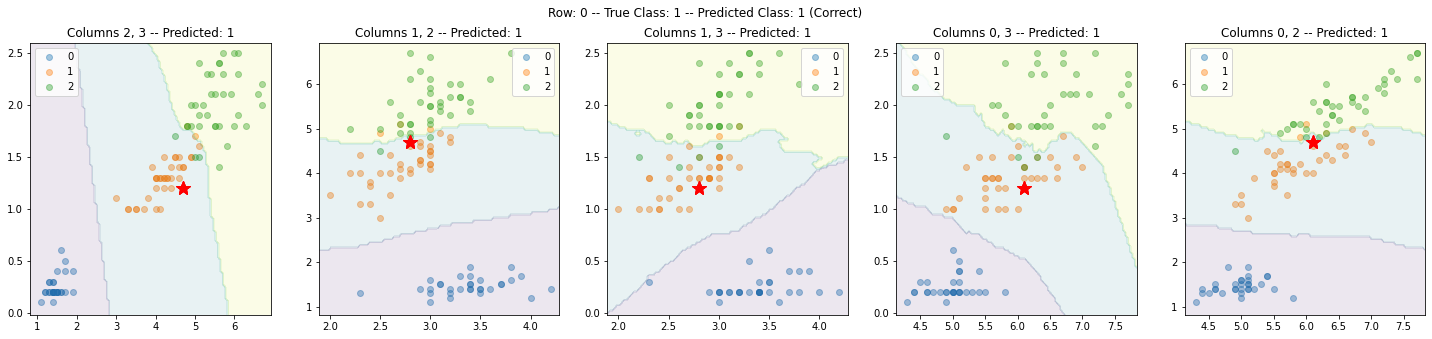

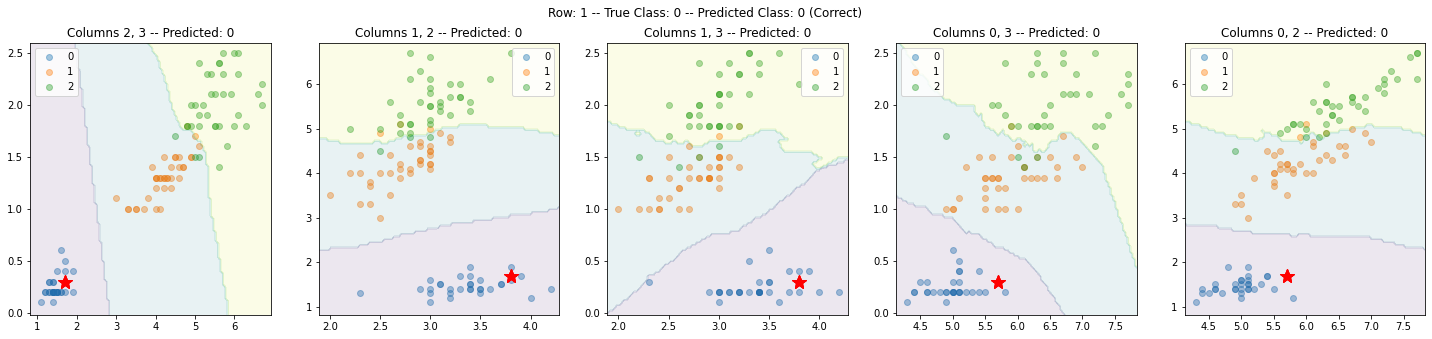

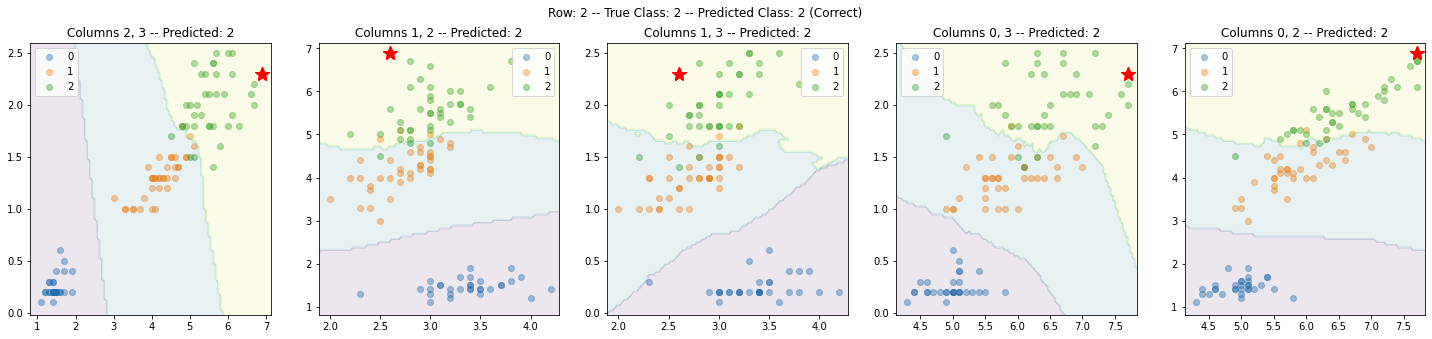

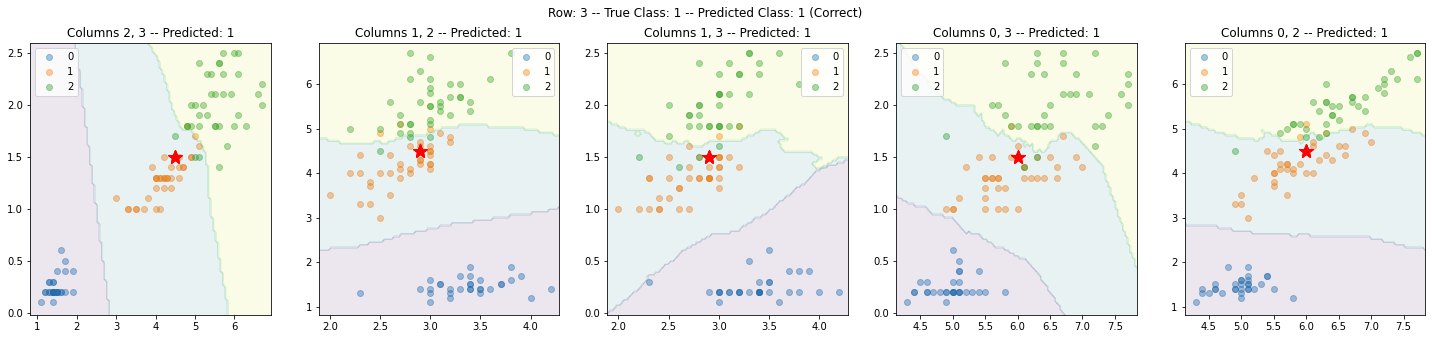

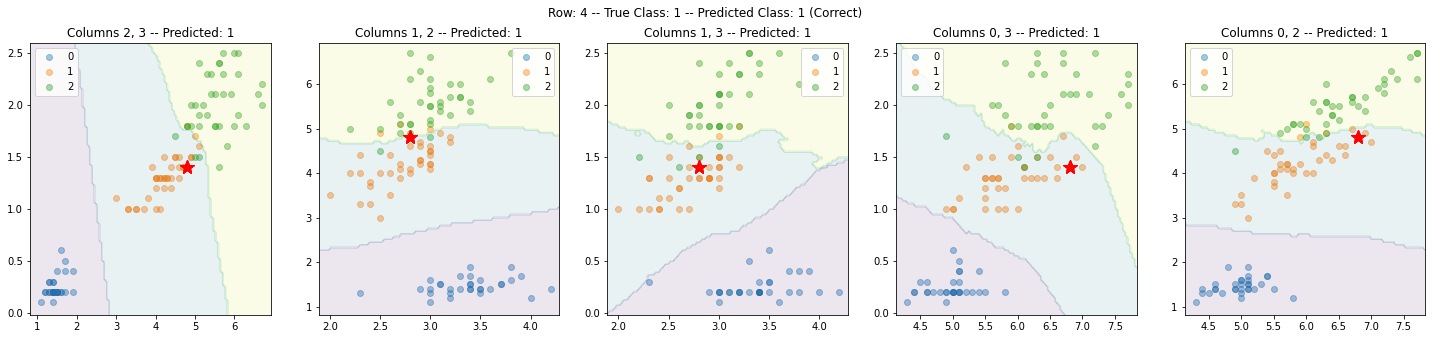



*********************************************
Calling for Breast Cancer
*********************************************
wrong_rows:  [8, 20, 36, 77, 82, 108, 114, 138, 148, 150, 164, 170]


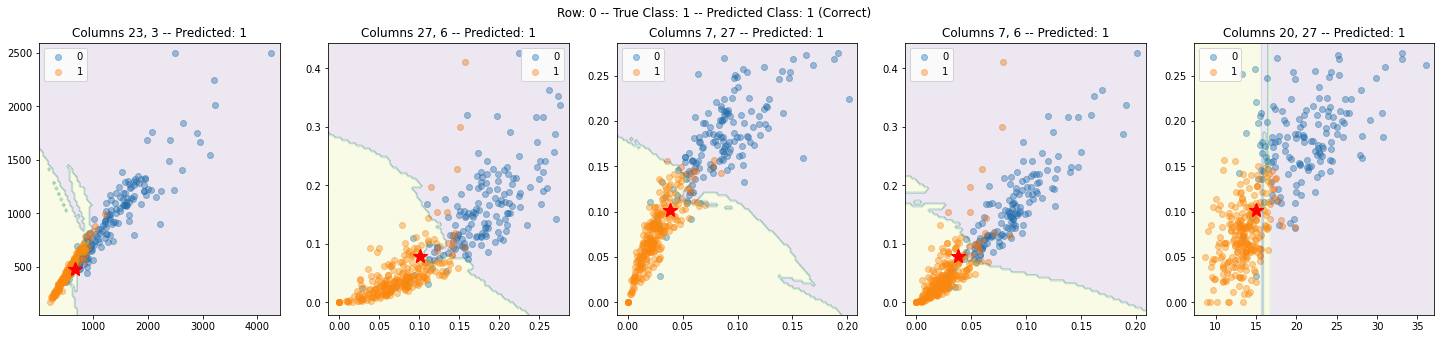

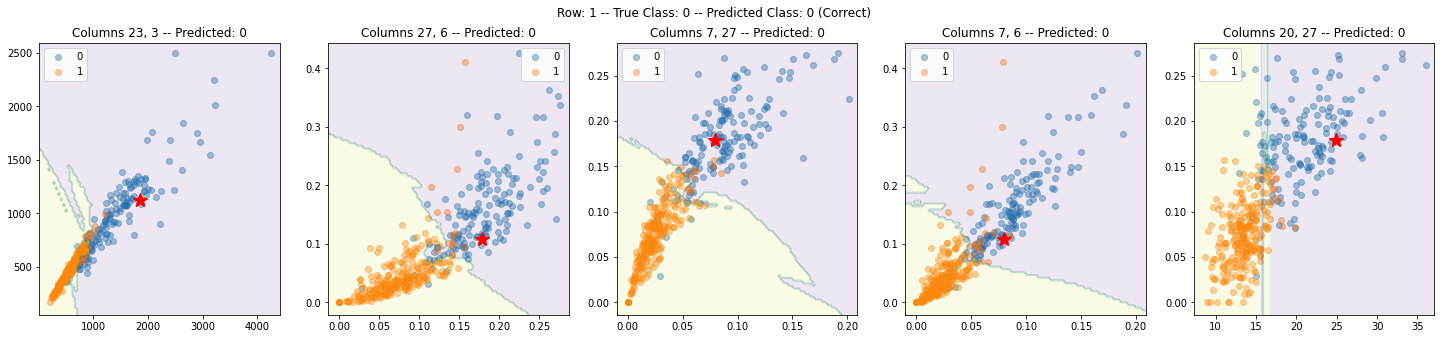

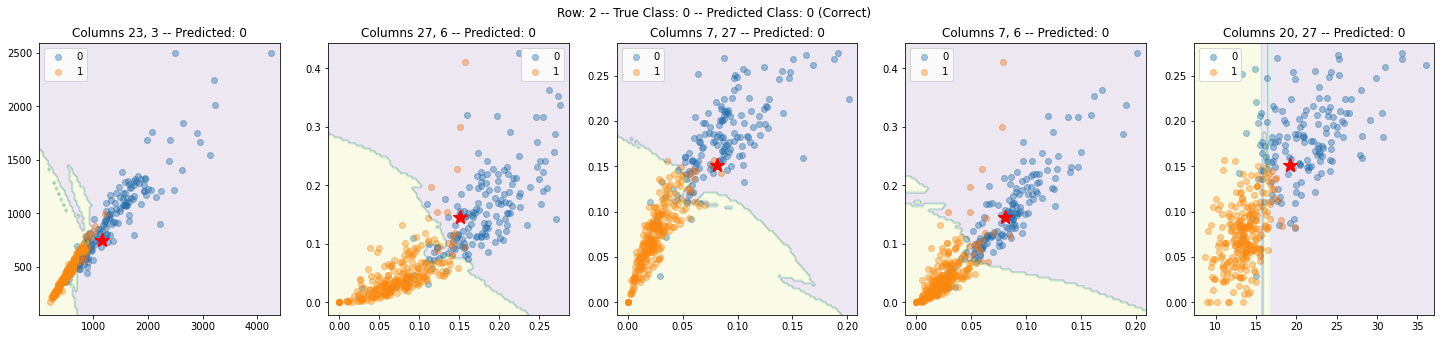

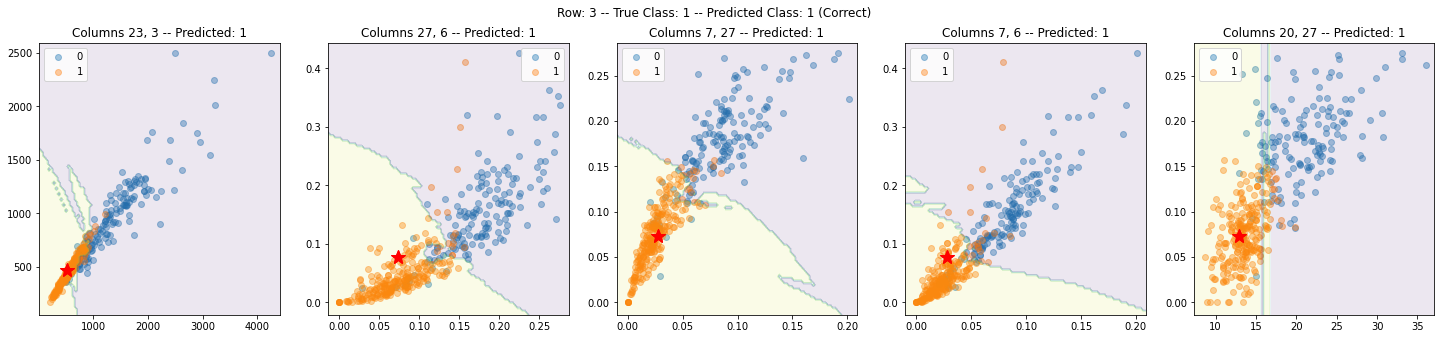

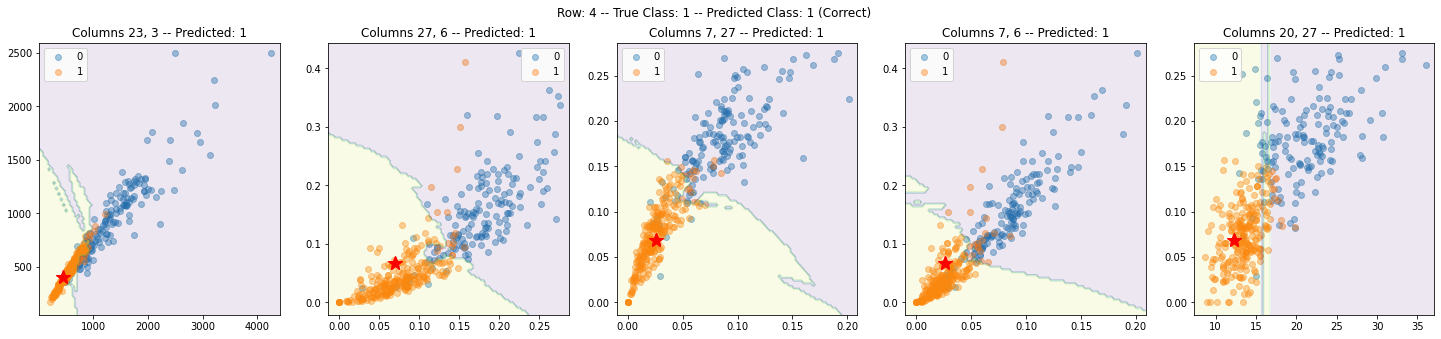



*********************************************
Calling for Wine
*********************************************
wrong_rows:  [4, 21, 27, 38, 50]


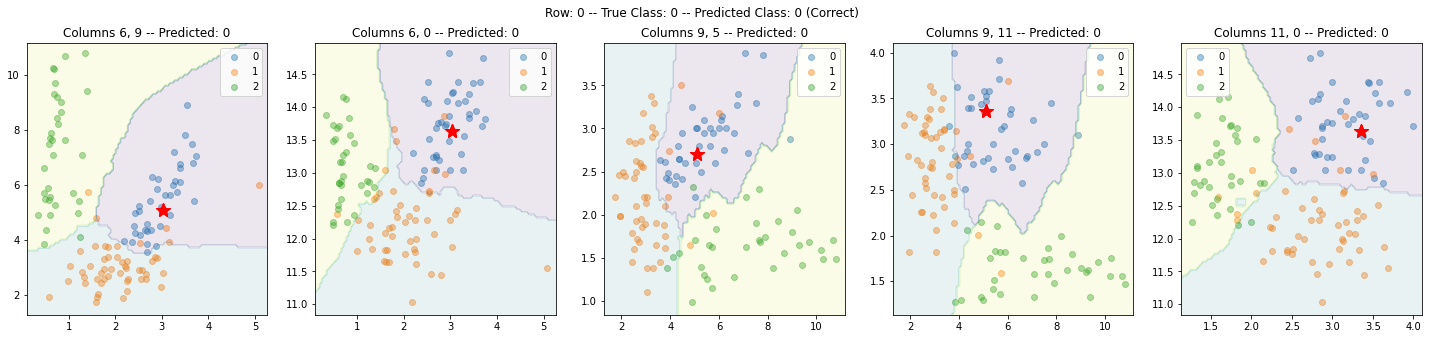

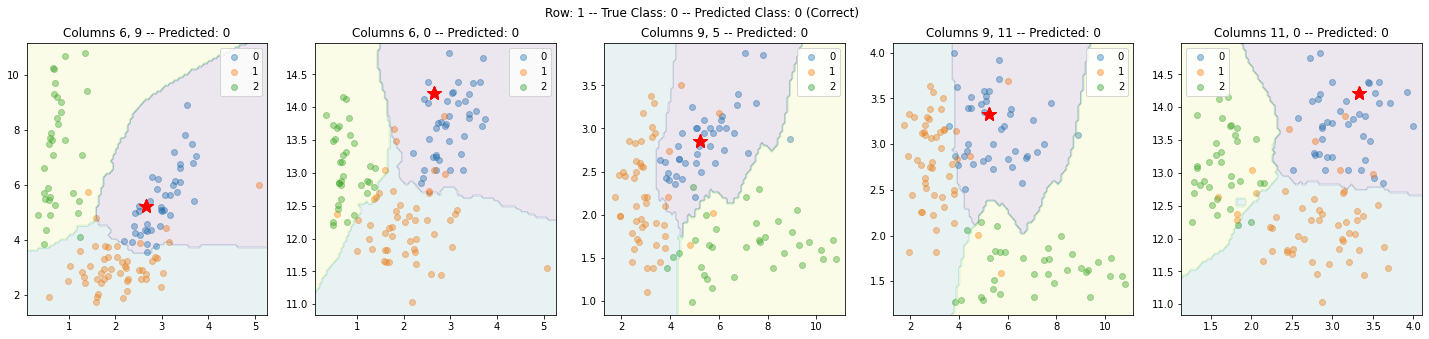

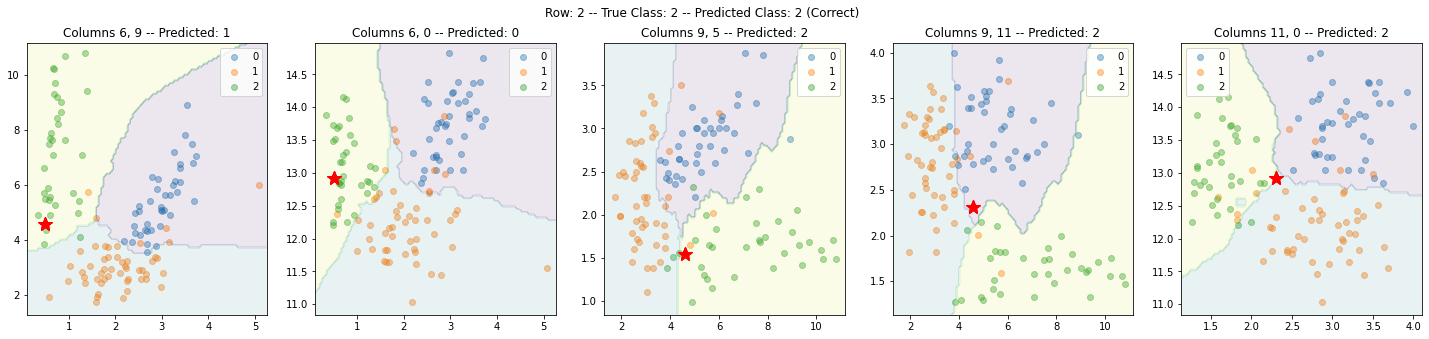

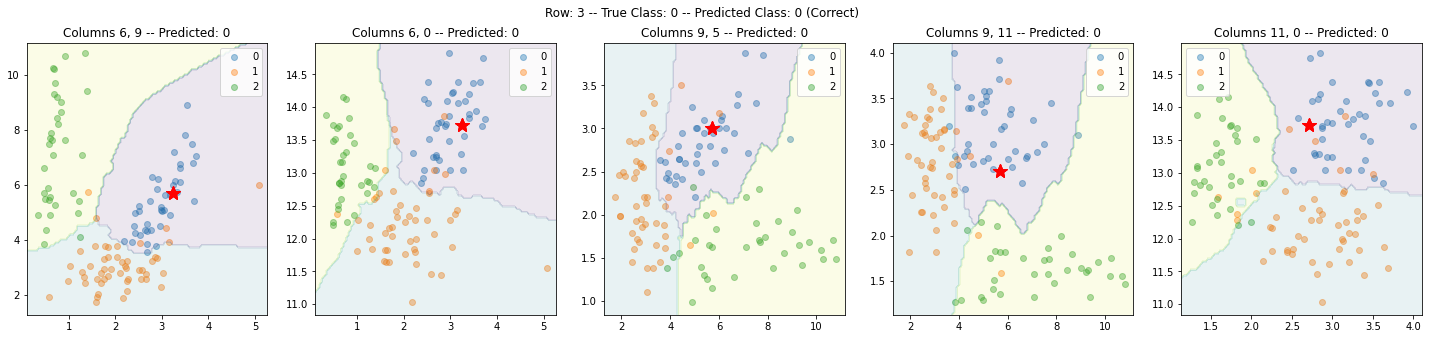

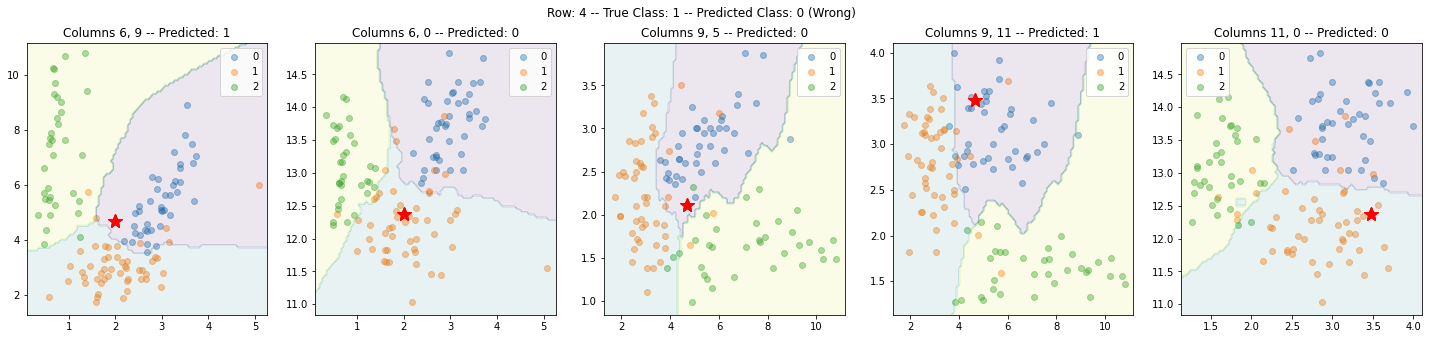

In [9]:
def visualize_models(load_method, file_name, num_rows_visualized=5):
    print("\n\n*********************************************")
    print("Calling for " + file_name)
    print("*********************************************")
    
    X,y = load_method()
    
    # Create an interpretable_knn to use for visualization
    ikNN = interpretable_knn()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    ikNN.fit(X_train, y_train)        
    pred_y_train = ikNN.predict(X_train)
    pred_y_test = ikNN.predict(X_test)
    wrong_rows = []
    for i in range(len(y_test)):
        if (pred_y_test[i] != y_test[i]):
            wrong_rows.append(i)
    print("wrong_rows: ", wrong_rows)

    num_rows_visualized = min(num_rows_visualized, len(X))
    for i in range(num_rows_visualized):
        ikNN.graph_2d_spaces(X_test.iloc[i], i, y_test[i:i+1][0])

visualize_models(get_iris, "Iris")
visualize_models(get_breast_cancer, "Breast Cancer")
visualize_models(get_wine, "Wine")

## Example using a Grid Search to Optimize sklearn's kNN Classifier

In [10]:
iris = load_iris()
parameters = {'n_neighbors':(1,10,50), 'metric':('euclidean','manhattan') }
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(iris.data, iris.target)
s = clf.score(iris.data, iris.target)
print("score: ", s)
b = clf.best_estimator_
print("best hyperparameters: ", b)
print("params: ", b.get_params())

score:  0.98
best hyperparameters:  KNeighborsClassifier(metric='euclidean', n_neighbors=10)
params:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


## Example using a Grid Search to Optimize interpretableKNN

In [12]:
def grid_search(X,y):
    parameters = { 'n_neighbors':(1,2,3,4,5,10,20), 
                    'method': ('simple majority', 'use proba'),
                    'weight_by_score': (True, False),
                    'num_best_spaces': (-1,1,2,3,4,5,10,20)
                 }
    iknn = interpretable_knn()
    clf2 = GridSearchCV(iknn, parameters, scoring='f1_macro')
    clf2.fit(X, y)
    s = clf2.score(X,y)
    print("score: ", s)
    b = clf2.best_estimator_
    print("best hyperparameters: ", b)

iris = load_iris()    
grid_search(iris.data, iris.target)

# X, y = load_breast_cancer(return_X_y=True, as_frame=True)
# grid_search(X,y)

# X, y = load_wine(return_X_y=True, as_frame=True)
# grid_search(X,y)


score:  0.9666633329999667
best hyperparameters:  interpretable_knn(method='simple majority', n_neighbors=20, num_best_spaces=4,
                  weight_by_score=False)
